# Observations so far

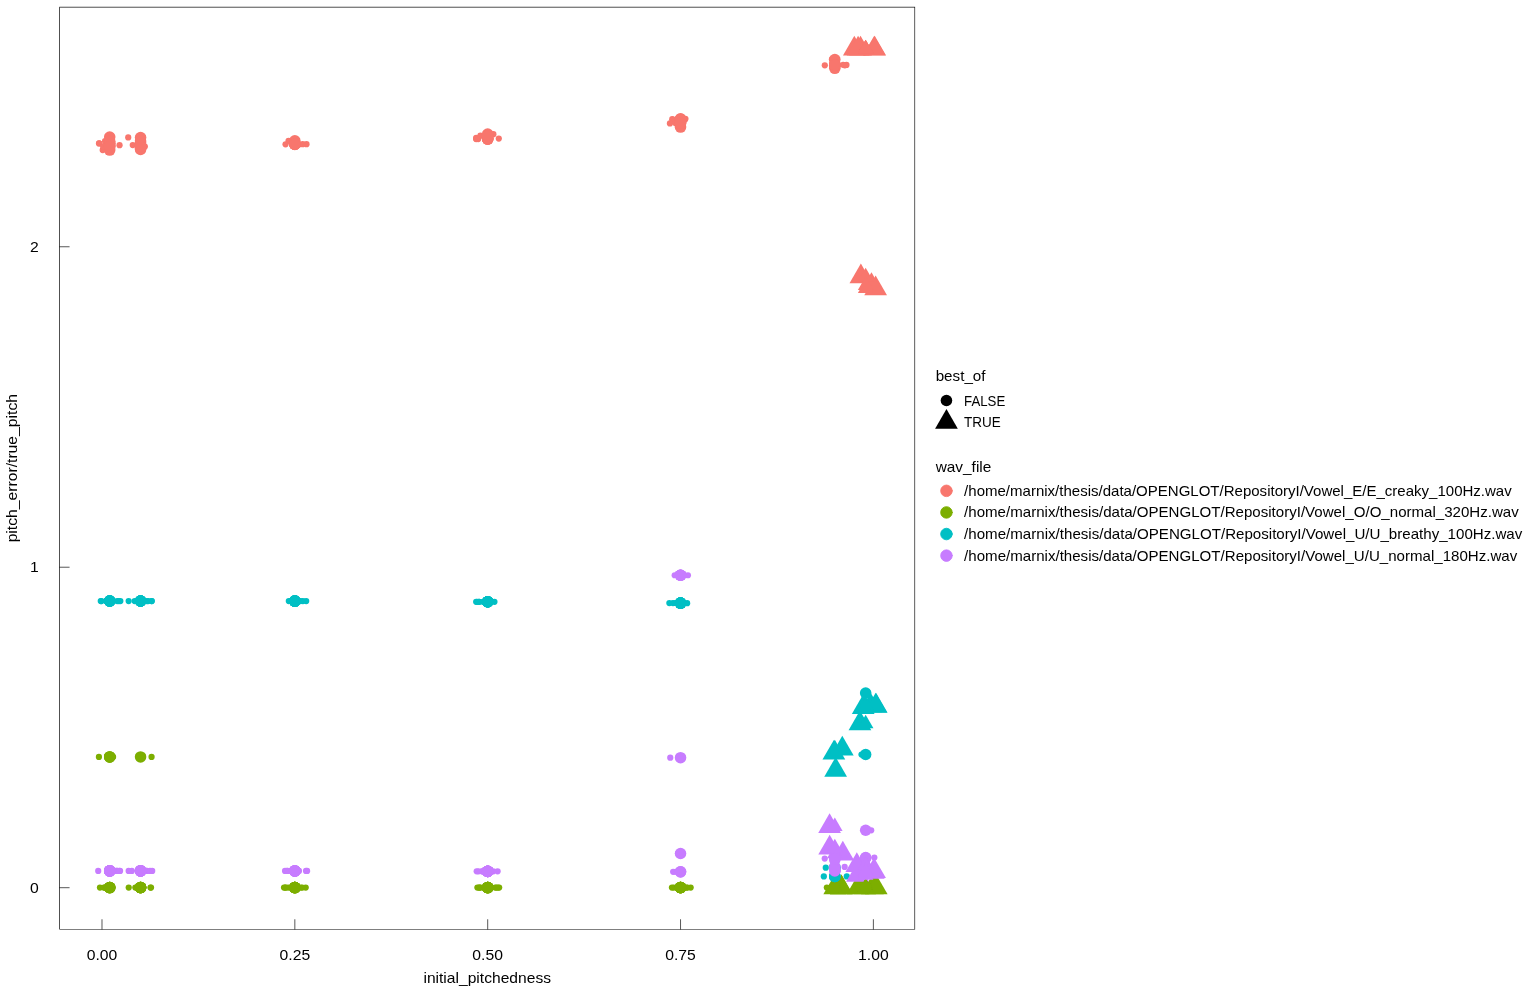

**Setting initial_pitchedness works**: we don't touch initialization but set our prior to expect higher or lower pitchedness. (TODO: can we still compare scores then?) This correctly makes the runs prefer pitchedness; the effect already works at `initial_pitchedness >= 0.75`. Note that Yoshii prior expects `initial_pitchedness ~= 0.5`, so it can go either way.

**Correctly inferring higher pitchedness...** improves $f_0$ error scores, but not by drastic amount. We see higher errors for creaky sources because the model is very smooth and needs to accomodate sharp features, so default to higher $T$. We also likely see higher errors for lower $T$ because less information in a given window size. Small theta (lower f0) are preferred slightly, because low frequency noise is easier to shape

In any case the IKLP model of gf(t) is really bad so not surprising a local explanation of noise + elaborate AR shaping is found. But perhaps a better global explanation of gf + AR exists but can't be found.

Improvements

- Formants from peak picking (our earlier thesis code), not root solving
- list Frame 37/{of total frames} and list filename stem too
- Plot inferred x(t), gf(t) etc
- Improve 'compression' metric, perhaps 1/compression, it does something good but also weird; if inference totally failed it gives 399.78 ~= I
- Give actually inferred pitch

Need to vary still (research question in brackets):

- P [graceful deteorization?]
- lambda [what does regularization accomplish? later: our AR prior]
- lengthscale of kernel r [less pitch errors if we can accomodate sharper features?]
- frame_length [number of pitch periods in frame length improves => less errors?]


In [1]:
import os
from pprint import pprint
from time import time

import jax
import jax.numpy as jnp
import numpy as np
import soundfile as sf


from iklp.hyperparams import Hyperparams
from iklp.periodic import periodic_kernel_phi
from iklp.state import compute_expectations, init_state
from iklp.vi import compute_elbo_bound, vi_step
from utils.audio import frame_signal, resample
from utils.stats import (
    average_list_of_dicts,
    kl_div,
    normalize_weights,
    weighted_pitch_error,
)

![alt text](image.png)


In [2]:
probes = [
    "/home/marnix/thesis/data/OPENGLOT/RepositoryI/Vowel_U/U_breathy_100Hz.wav",  # [0]: run 159: top left
    "/home/marnix/thesis/data/OPENGLOT/RepositoryI/Vowel_U/U_normal_180Hz.wav",  # [1]: run 119: top middle
    "/home/marnix/thesis/data/OPENGLOT/RepositoryI/Vowel_E/E_creaky_100Hz.wav",  # [2]: run 105: top right
    "/home/marnix/thesis/data/OPENGLOT/RepositoryI/Vowel_O/O_normal_320Hz.wav",  # [3]: run 245: bottom right
]

In [ ]:
seed = 0
wav_file = probes[3]
initial_pitchedness = 0.5

In [4]:
# From OPENGLOT paper Table 1
true_resonance_frequencies = {
    "a": [730, 1090, 2440, 3500],
    "e": [530, 1840, 2480, 3500],
    "i": [390, 1990, 2550, 3500],
    "o": [570, 840, 2410, 3500],
    "u": [440, 1020, 2240, 3500],
    "ae": [660, 1720, 2410, 3500],
}

In [5]:
vowel, modality, true_pitch = (
    wav_file.split("/")[-1].split(".")[-2].split("_")[:3]
)
vowel = vowel.lower()
modality = modality.lower()
true_pitch = int(true_pitch.lower()[:-2])  # Remove 'Hz' from the pitch string

f1, f2, f3, f4 = true_resonance_frequencies[vowel]

In [ ]:
vi_runs = 1

# Use same parameters as in OPENGLOT and Yoshii
P = 9
I = 400
f0_min = 70  # Typical lower bound (Nielsen 2013)
f0_max = 400

# Adjust these together
target_sr = 8000
frame_len = 1024
hop = 80

noise_floor_db = -60.0
max_iter = 50
criterion = 0.0001

verbose = True

In [ ]:
audio, sr_in = sf.read(wav_file, always_2d=False, dtype="float64")

# Split channels
x = audio[:, 0]
dgf = audio[:, 1]

x = resample(x, sr_in, target_sr)
dgf = resample(dgf, sr_in, target_sr)

# Normalize data to unit power
scale = 1 / np.sqrt(np.mean(x**2))
x = x * scale
dgf = dgf * scale

print(f"→ Loaded {wav_file} ({len(x)} samples, {sr_in} Hz)")

→ Loaded /home/marnix/thesis/data/OPENGLOT/RepositoryI/Vowel_O/O_normal_320Hz.wav (1600 samples, 8000 Hz)


In [ ]:
f0, Phi = periodic_kernel_phi(
    I=I,
    M=frame_len,
    fs=target_sr,
    f0_min=f0_min,
    f0_max=f0_max,
    noise_floor_db=noise_floor_db,
)

aw = initial_pitchedness / (1 - initial_pitchedness)

h = Hyperparams(Phi, P=P, aw=aw)

vi_step = jax.jit(vi_step)
compute_elbo_bound = jax.jit(compute_elbo_bound)
compute_expectations = jax.jit(compute_expectations)

In [ ]:
true_posterior = np.zeros_like(f0)
q = np.abs(f0 - true_pitch).argmin().item()
true_posterior[q] = 1.0

uniform_prior = np.ones_like(f0) / len(f0)


def compute_frame_stats(frame, state):
    E = compute_expectations(state)

    # Characterize the posterior of theta (fundamental frequency)
    theta_posterior = normalize_weights(E.theta)

    compression = np.exp(kl_div(theta_posterior, uniform_prior))
    fitness = np.exp(kl_div(true_posterior, theta_posterior))

    # Fundamental frequency error
    estimated_pitch_mean = theta_posterior @ f0
    estimated_pitch_var = theta_posterior @ (f0 - estimated_pitch_mean) ** 2

    # Power and pitchedness
    frame_power = np.mean(frame**2)
    nu_e = E.nu_e
    nu_w = E.nu_w
    pitchedness = nu_w / (nu_e + nu_w)

    # AR
    a = state.xi.delta_a

    stats = {
        "estimated_pitch_mean": estimated_pitch_mean,
        "estimated_pitch_var": estimated_pitch_var,
        "nu_e": E.nu_e,
        "nu_w": E.nu_w,
        "pitchedness": pitchedness,
    }

    return stats

In [10]:
def process_frame(key, frame_index, attempt_index, frame, h):
    state = init_state(key, frame, h)
    score = -jnp.inf

    stats0 = compute_frame_stats(frame, state)

    started = time()
    for i in range(max_iter):
        state = vi_step(state)
        lastscore = score
        score = compute_elbo_bound(state)

        if i == 0:
            improvement = 1.0
        else:
            improvement = (score - lastscore) / jnp.abs(lastscore)

        if verbose:
            print(
                f"Frame {frame_index}, attempt {attempt_index}, iter {i}: "
                f"bound = {score:.2f} "
                f"({improvement:+.5f} improvement)"
            )

        if improvement < 0.0:
            break
        if improvement < criterion:
            break
        if jnp.isnan(improvement) and i > 0:
            break

    walltime = time() - started

    stats = compute_frame_stats(frame, state)
    stats["initial_pitchedness"] = stats0["pitchedness"]
    stats["frame_index"] = frame_index
    stats["attempt_index"] = attempt_index
    stats["num_iters"] = i + 1
    stats["time_per_iter"] = walltime / (i + 1)
    stats["score"] = score

    if verbose:
        pprint(stats)

    return stats

In [11]:
frames = frame_signal(x, frame_len, hop)

master_key = jax.random.PRNGKey(seed)
keys = jax.random.split(master_key, len(frames))

print("Number of frames:", len(frames))

Number of frames: 8


In [ ]:
frame_stats = [
    process_frame(sk, idx, rstart, frame, h)
    for idx, (key, frame) in enumerate(zip(keys, frames))
    for rstart, sk in enumerate(jax.random.split(key, vi_runs))
]


# Export also:
# initial pitchedness
# F1, F2, F3, F4 (est)

Frame 0, attempt 0, iter 0: bound = -765.81 (+1.00000 improvement)
Frame 0, attempt 0, iter 1: bound = 36.32 (+1.04743 improvement)
Frame 0, attempt 0, iter 2: bound = 469.81 (+11.93413 improvement)
Frame 0, attempt 0, iter 3: bound = 779.83 (+0.65990 improvement)
Frame 0, attempt 0, iter 4: bound = 1083.20 (+0.38902 improvement)
Frame 0, attempt 0, iter 5: bound = 1374.12 (+0.26858 improvement)
Frame 0, attempt 0, iter 6: bound = 1665.21 (+0.21184 improvement)
Frame 0, attempt 0, iter 7: bound = 1739.65 (+0.04470 improvement)
Frame 0, attempt 0, iter 8: bound = 1866.11 (+0.07269 improvement)
Frame 0, attempt 0, iter 9: bound = 2084.45 (+0.11700 improvement)
Frame 0, attempt 0, iter 10: bound = 2207.89 (+0.05922 improvement)
Frame 0, attempt 0, iter 11: bound = 2237.24 (+0.01329 improvement)
Frame 0, attempt 0, iter 12: bound = 2247.45 (+0.00457 improvement)
Frame 0, attempt 0, iter 13: bound = 2252.84 (+0.00240 improvement)
Frame 0, attempt 0, iter 14: bound = 2255.21 (+0.00105 improv

KeyboardInterrupt: 